## Regression
Objectives are:
- Get familiar with linear models in MLJ
- Develop understanding about the bias-variance trade-off

### Getting ready
Let's import a few packages, prepare some data, and get started with linear regression. 

In [1]:
using MLJ, Random, Printf

In [2]:
#import Pkg; Pkg.add("MLJLinearModels")

In [3]:
LinearRegressor = @load LinearRegressor pkg=MLJLinearModels

[ Info: For silent loading, specify `verbosity=0`. 


import MLJLinearModels ✔


MLJLinearModels.LinearRegressor

In [4]:
# make some example data
function make_data(N=50, ϵ=0.8, rseed=1)
    # randomly sample the data
    Random.seed!(rseed)
    X = rand(N, 1).^2           
    y = 10 .- 1 ./ (X[:,1] .+ 0.1) + ϵ*randn(N) 
    return X, y
end

X, y = make_data()

([0.05571174026441932; 0.12007404112451132; … ; 0.058366022004895; 0.7829363848582092], [2.897832133150603, 6.359602263879208, 3.8651946545621465, 0.9984844858163111, 7.0033874252199775, 3.687460060868415, 8.981893681761616, 8.801885348299503, 2.2717279889976925, 8.613389455666502  …  5.416322756381304, 9.06241088166888, 8.36414278899569, 6.605343129914482, 1.936019466686923, 8.315993769768003, 9.006504880656276, 8.556122085428552, 4.693349864908608, 8.735189091567314])

In [5]:
xf = 0.0:1.0:1000     # use 1000 points in [-0.1, 1.0) to plot out prediction

0.0:1.0:1000.0

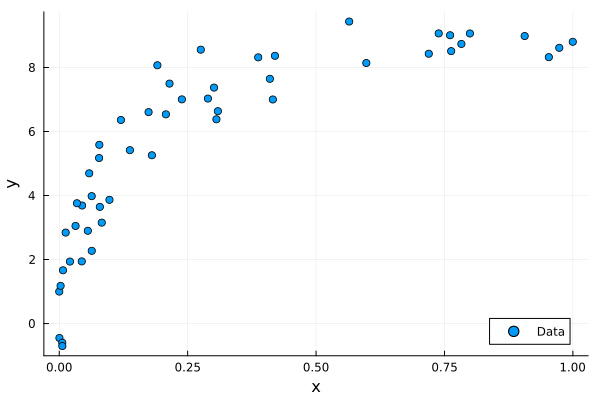

In [6]:
using Plots
scatter(X[:,1], y, xlabel="x", ylabel="y", label="Data", legend=:bottomright)

As in a typical MLJ workflow, let's create a model, then a machine, and train it with our data: 

In [32]:
using DataFrames

X_df = DataFrame(X) # Convert the matrix to a DataFrame

model = LinearRegressor()
mach = machine(model, X_df, y)
fit!(mach)

[ Info: Training machine(LinearRegressor(fit_intercept = true, …), …).
┌ Info: Solver: MLJLinearModels.Analytical
│   iterative: Bool false
└   max_inner: Int64 200


trained Machine; caches model-specific representations of data
  model: LinearRegressor(fit_intercept = true, …)
  args: 
    1:	Source @172 ⏎ Table{AbstractVector{Continuous}}
    2:	Source @114 ⏎ AbstractVector{Continuous}


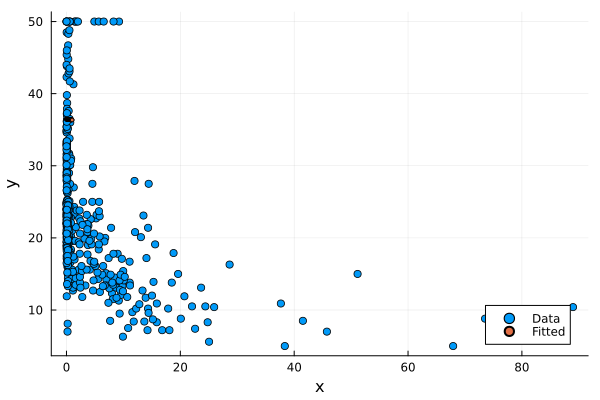

In [33]:
xf = hcat(0.0:0.01:1.0)    # some testing x values
pred = predict(mach, xf)
scatter(X_df[:,1], y, xlabel="x", ylabel="y", label="Data", legend=:bottomright)
scatter!(xf, pred, label="Fitted", ms=2)

The linear regressor seems to work. 

### Polynomial regression and model selection
We now turn to a univariate polynomial regression package and see how it works. This gives us a good scenario to take a look of model selection. Let's install the package first: 

In [9]:
# import Pkg; Pkg.add("Polynomials")
using Polynomials

To use the univariate polynomial models let's first transform the data into 1-D array:

In [10]:
xs = X[:, 1]

50-element Vector{Float64}:
 0.05571174026441932
 0.12007404112451132
 0.09778564804593431
 6.25567637522e-5
 0.2387424977182995
 0.04450758232200489
 0.9061447180462606
 0.9998093268871527
 0.06333385436841771
 0.9735105195692766
 0.30885927106244443
 0.1910633814673287
 0.18038525252920481
 ⋮
 0.031771673427793454
 0.3013821937082247
 0.13761923270387758
 0.7995326911763806
 0.41997366058612495
 0.17392182268807274
 0.02089919605334001
 0.3873857219853142
 0.76096736713962
 0.2755983900899055
 0.058366022004895
 0.7829363848582092

As an example, we can do quadratic fitting to the data (note the novel use of plot() and the use of splat (dot dot dot) to represent a series of arguments). 

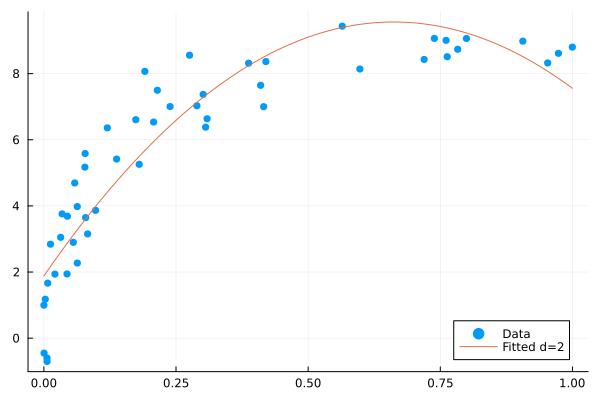

In [11]:
f_poly = fit(xs, y, 2) # degree = 2

scatter(xs, y, markerstrokewidth=0, label="Data", legend=:bottomright)
plot!(f_poly, extrema(X[:,1])..., label="Fitted d=2")

To look into generalization ability, we do a 70/30 random split: 

In [12]:
train, test = partition(eachindex(y), 0.7, shuffle=true, rng=13);

In [13]:
using Printf

**Task 1**: Use the polynomial fitting of degree 2, calculate the RMS measures for the training and testing samples, and plot out the training/testing samples, the fitted curve, and the relevant RMS values (show these as the title for the plot). 

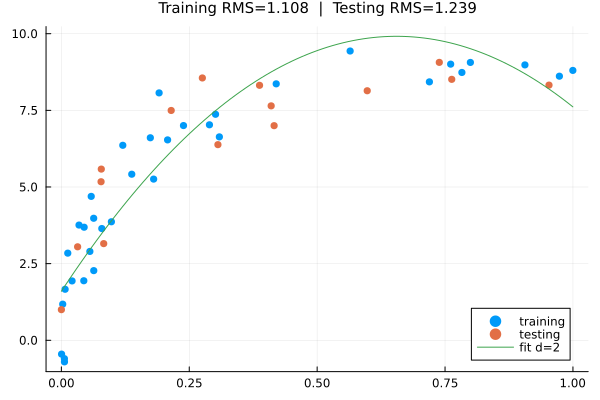

In [14]:
f_poly = fit(xs[train], y[train], 2) # degree = 2
err_msg = @sprintf "Training RMS=%4.3f  |  Testing RMS=%4.3f" rms(y[train], f_poly.(xs[train])) rms(y[test], f_poly.(xs[test]))
scatter(xs[train], y[train], markerstrokewidth=0, label="training", legend=:bottomright)
scatter!(xs[test], y[test], markerstrokewidth=0, label="testing", legend=:bottomright)
plot!(f_poly, extrema(xs)..., label="fit d=2", title=err_msg, titlefontsize=10)

**Task 2a**. For degrees from 1 to 15, repeat Task 1 and generate the plots. 

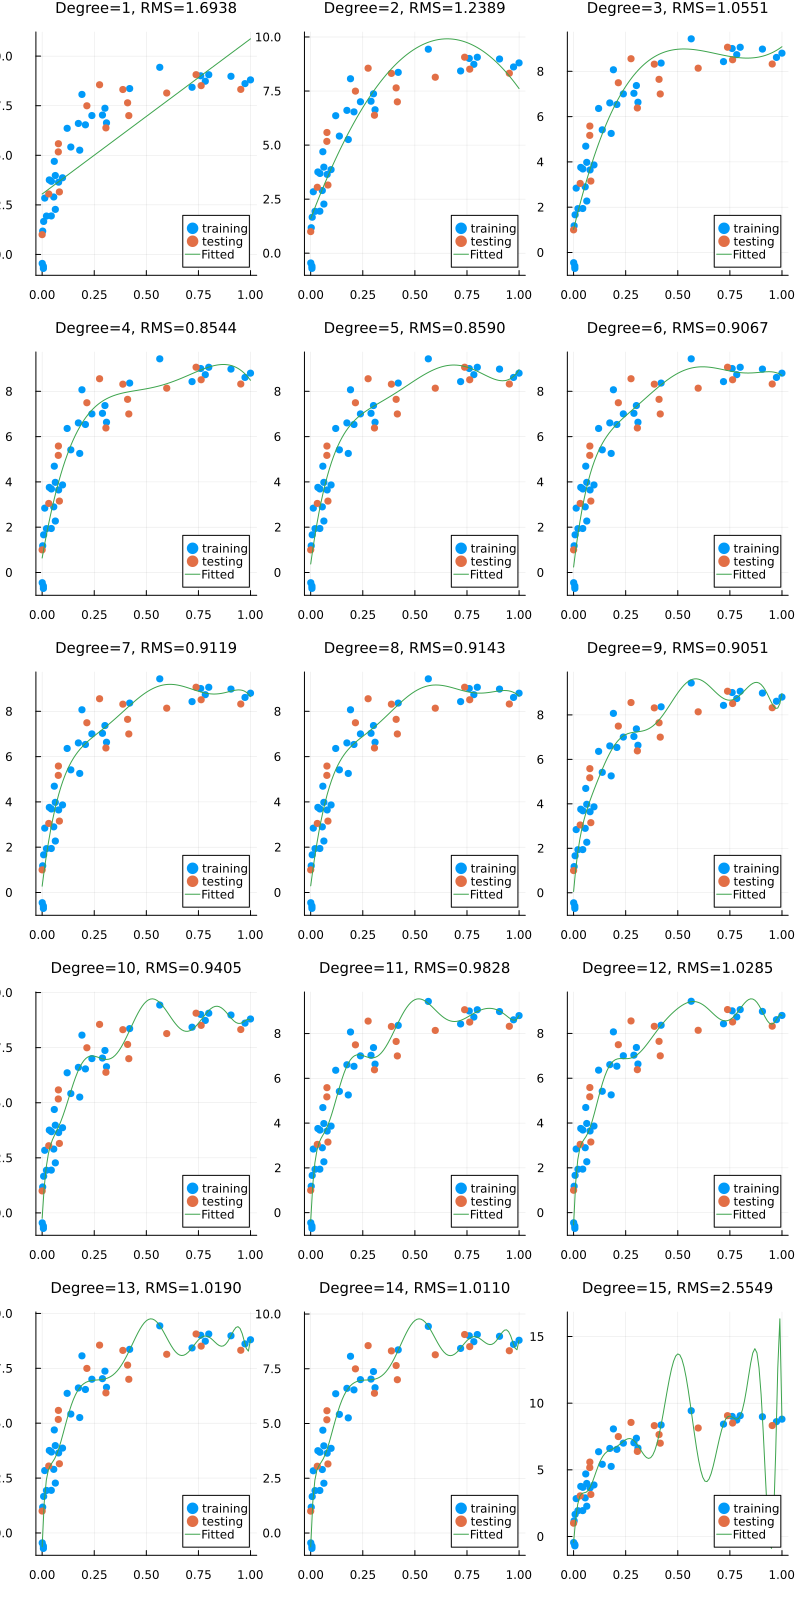

In [15]:
plots = Any[]
rmss_tr = Float64[]
rmss_te = Float64[]
for deg = 1:15
    f_poly = fit(xs[train], y[train], deg) 
    rmsv = rms(y[train], f_poly.(xs[train]))
    push!(rmss_tr, rmsv)
    rmsv = rms(y[test], f_poly.(xs[test]))
    push!(rmss_te, rmsv)
    ttl = @sprintf "Degree=%d, RMS=%6.4f" deg rmsv 
    p = scatter(xs[train], y[train], markerstrokewidth=0, label="training", legend=:bottomright)
    p = scatter!(xs[test], y[test], markerstrokewidth=0, label="testing")
    p = plot!(f_poly, extrema(xs)..., label="Fitted", title=ttl, titlefontsize=10)
    push!(plots, p)
end
plot(plots..., layout=(5,3), size=(800,1600))

**Task 2b**. Plot out the training and testing RMSs against the degrees. 

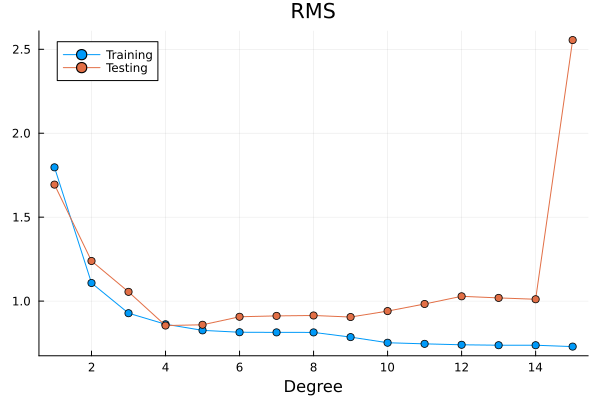

In [16]:
# code for 2b
plot(1:15, rmss_tr, label="Training", xlabel="Degree", marker=:true, legend=:topleft)
plot!(1:15, rmss_te, label="Testing", xlabel="Degree", marker=:true, title="RMS")

### Multivariate regression 

In reality we often work with multivariate datasets. So let's use the Boston dataset from the RDatasets package: 

In [17]:
# import Pkg; Pkg.add("RDatasets")
using RDatasets, DataFrames
boston = dataset("MASS", "Boston")

Row,Crim,Zn,Indus,Chas,NOx,Rm,Age,Dis,Rad,Tax,PTRatio,Black,LStat,MedV
,Float64,Float64,Float64,Int64,Float64,Float64,Float64,Float64,Int64,Int64,Float64,Float64,Float64,Float64
1,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.09,1,296,15.3,396.9,4.98,24.0
2,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.9,9.14,21.6
3,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
5,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.9,5.33,36.2
6,0.02985,0.0,2.18,0,0.458,6.43,58.7,6.0622,3,222,18.7,394.12,5.21,28.7
7,0.08829,12.5,7.87,0,0.524,6.012,66.6,5.5605,5,311,15.2,395.6,12.43,22.9
8,0.14455,12.5,7.87,0,0.524,6.172,96.1,5.9505,5,311,15.2,396.9,19.15,27.1
9,0.21124,12.5,7.87,0,0.524,5.631,100.0,6.0821,5,311,15.2,386.63,29.93,16.5


In [18]:
describe(boston, :mean, :std, :eltype)

Row,variable,mean,std,eltype
,Symbol,Float64,Float64,DataType
1,Crim,3.61352,8.60155,Float64
2,Zn,11.3636,23.3225,Float64
3,Indus,11.1368,6.86035,Float64
4,Chas,0.06917,0.253994,Int64
5,NOx,0.554695,0.115878,Float64
6,Rm,6.28463,0.702617,Float64
7,Age,68.5749,28.1489,Float64
8,Dis,3.79504,2.10571,Float64
9,Rad,9.54941,8.70726,Int64


There are several integer attributes - we simply convert them into float values: 

In [19]:
data = coerce(boston, autotype(boston, :discrete_to_continuous));

... and extract the X and y arrays - our plan is to predict the MedV attribute using all other attributes: 

In [20]:
y = data.MedV
X = select(data, Not(:MedV));

In [21]:
# Stardardization is not used in the Data Science Tutorials; Tried here but doesn't really help; not used. 
transformer_instance = Standardizer()
transformer_model = machine(transformer_instance, X)
fit!(transformer_model)
X1 = MLJ.transform(transformer_model, X);

[ Info: Training machine(Standardizer(features = Symbol[], …), …).


Let's do an 80/20 random split and fit the model. The coefficients of the linear model are printed out: 

In [22]:
train, test = partition(eachindex(y), 0.8, shuffle=true, rng=13);

reg = LinearRegressor()
mach = machine(reg, X, y)
fit!(mach, rows=train)

fp = fitted_params(mach)
coefs = fp.coefs
intercept = fp.intercept
for (name, val) in coefs
    println("$(rpad(name, 8)):  $(round(val, sigdigits=3))")
end
println("Intercept: $(round(intercept, sigdigits=3))")

[ Info: Training machine(LinearRegressor(fit_intercept = true, …), …).
┌ Info: Solver: MLJLinearModels.Analytical
│   iterative: Bool false
└   max_inner: Int64 200


Crim    :  -0.105
Zn      :  0.0408
Indus   :  0.0584
Chas    :  2.13
NOx     :  -17.0
Rm      :  3.74
Age     :  0.00182
Dis     :  -1.38
Rad     :  0.288
Tax     :  -0.0118
PTRatio :  -0.965
Black   :  0.0112
LStat   :  -0.562
Intercept: 35.7


In [23]:
pred = predict(mach, rows=test)
round(rms(pred, y[test]), sigdigits=4)

5.064

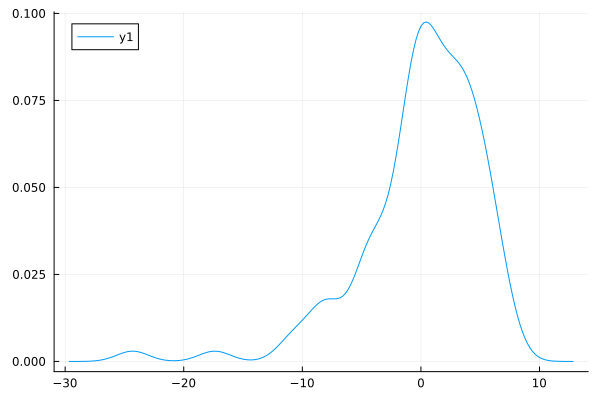

In [24]:
#plot(pred.-y[test], seriestype=:sticks)
using StatsPlots
density(pred.-y[test])

In [25]:
reg = LinearRegressor()
mach = machine(reg, X1, y)
fit!(mach)

fp = fitted_params(mach)
coefs = fp.coefs
intercept = fp.intercept
for (name, val) in coefs
    println("$(rpad(name, 8)):  $(round(val, sigdigits=3))")
end
println("Intercept: $(round(intercept, sigdigits=3))")

Crim    :  -0.929
Zn      :  1.08
Indus   :  0.141
Chas    :  0.682
NOx     :  -2.06
Rm      :  2.68
Age     :  0.0195
Dis     :  -3.11
Rad     :  2.66
Tax     :  -2.08
PTRatio :  -2.06
Black   :  0.85
LStat   :  -3.75
Intercept: 22.5


[ Info: Training machine(LinearRegressor(fit_intercept = true, …), …).
┌ Info: Solver: MLJLinearModels.Analytical
│   iterative: Bool false
└   max_inner: Int64 200


In [26]:
pred = predict(mach, rows=test)
round(rms(pred, y[test]), sigdigits=4)

4.96

Let's do some proper performance evaluation. 

**Task 3**. Use a 10-fold cross validation process and MLJ's evaluate() function to obtain the linear regressor's performance on rms. Report the mean RMS as well as the standard deviation. 

In [27]:
cv=CV(nfolds=10)
reg = LinearRegressor()
perf = evaluate(reg, X, y, resampling=cv, measure=rms, verbosity=0)
mean(perf.per_fold[1]), std(perf.per_fold[1])

(5.180845679340246, 2.9559909019906447)

In [28]:
RidgeRegressor = @load RidgeRegressor pkg=MLJLinearModels
reg = RidgeRegressor()
mach = machine(reg, X, y)
fit!(mach)

fp = fitted_params(mach)
coefs = fp.coefs
intercept = fp.intercept
for (name, val) in coefs
    println("$(rpad(name, 8)):  $(round(val, sigdigits=3))")
end

import MLJLinearModels ✔


[ Info: For silent loading, specify `verbosity=0`. 
[ Info: Training machine(RidgeRegressor(lambda = 1.0, …), …).
┌ Info: Solver: MLJLinearModels.Analytical
│   iterative: Bool false
└   max_inner: Int64 200


Crim    :  -0.096
Zn      :  0.0551
Indus   :  -0.0434
Chas    :  0.178
NOx     :  -0.0414
Rm      :  0.93
Age     :  0.0218
Dis     :  -0.826
Rad     :  0.329
Tax     :  -0.0168
PTRatio :  -0.768
Black   :  0.00835
LStat   :  -0.753


**Task 4**. Use a 10-fold cross validation process and MLJ's evaluate() function to obtain the ridge regressor's performance on rms. Report the mean RMS as well as the standard deviation. 

In [29]:
cv=CV(nfolds=10)
reg = RidgeRegressor()
perf = evaluate(reg, X, y, resampling=cv, measure=rms, verbosity=0)
mean(perf.per_fold[1]), std(perf.per_fold[1])

(5.209351167351836, 1.8769404322506011)

Some more exploration on Lasso. Not used. 

In [30]:
LassoRegressor = @load LassoRegressor pkg=MLJLinearModels

import MLJLinearModels ✔


[ Info: For silent loading, specify `verbosity=0`. 


MLJLinearModels.LassoRegressor

In [31]:
cv=CV(nfolds=10)
reg = LassoRegressor()
perf = evaluate(reg, X1, y, resampling=cv, measure=rms, verbosity=0)
mean(perf.per_fold[1]), std(perf.per_fold[1])

(5.453396182778676, 2.9912928398609284)